# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of OHC on the spatial distribution of MET ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.08.18 ** <br>
** Last Update  : 2018.08.18 ** <br>
Description     : This notebook includes the result of the lag regression of OHC on the spatial distribution of MET. It aims to unveil the relation between the OHC and MET and try to illustrate how the ocean drives the atmosphere through the change of OHC. Besides, 2D fields like SST, are studied as well aganist the variation of OHC.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/yang/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_ORAS4_mask = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/spatial'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # MET
    # 4D fields [year, month, lat, lon]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_0_ERAI_point = dataset_ERAI_AMET.variables['E_total'][:,:,:,:]/1000 # from Tera Watt to Peta Watt
    OMET_0_ORAS4_point = dataset_ORAS4_OMET.variables['E_total'][21:-1,:,180:,:]/1000
    OHC_0_ORAS4_point = dataset_ORAS4_OHC.variables['OHC_total'][21:-1,:,180:,:]/1000
    # 3D fields [time, lat, lon]
    SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:]
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:]
    SST_ERAI_mask = np.ma.getmaskarray(SST_ERAI[0,:,:])
    #AMET_vert_ERAI_reverse = dataset_ERAI_AMET.variables['E_vert'][:]/1000
    # 3D fields [year, month, lat]
    AMET_0_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000
    
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000
    # 3D fields [year, month, lat]
    OHC_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OHC_atl_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_int'][21:-1,:,180:]/1000
    OHC_atl_100_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_100_int'][21:-1,:,180:]/1000
    OHC_atl_300_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_300_int'][21:-1,:,180:]/1000
    OHC_atl_700_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_700_int'][21:-1,:,180:]/1000
    OHC_atl_2000_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_2000_int'][21:-1,:,180:]/1000   
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    longitude_AMET_ERAI = dataset_ERAI_AMET.variables['longitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    gphiv_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:, :]
    glamv_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:, :]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]

*********************** extract variables *************************


Prepare OHC data. For the convergence of OHC, the OHC between a narrow band is more explicit.<br>
We choose the OHC band based on the lead/lag reanalysis of AMET and OHC at different latitudes.<br>
In this case, we want to check two key locations:<br>
*between 30-35 degree north (Gulf Stream)*<br>
*between 50-55 degree north*

In [3]:
    # index 55N: 45 50N: 38 35N: 18 30N: 12 
    OHC_atl_int_ORAS4_band_50_55 = np.sum(OHC_atl_int_ORAS4[:, :, 38:46], 2)
    OHC_atl_int_ORAS4_band_30_35 = np.sum(OHC_atl_int_ORAS4[:, :, 12:19], 2)

In [ ]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('**************!@#$%^&*     regression of ORAS4 - ERAI   !@#$%^&**************')
    print ('=================   AMET + 0 & OHC + atl + 0 + band 30-35   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_30_35)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI_point)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    lag = -48
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_AMET_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_AMET_ERAI, longitude_AMET_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'amet_ohc',
                                   'spatial_ORAS4_atl_OHC_30_35_lag_{}_ERAI_AMET_interannual.png'.format(lag)))

In [ ]:
    print ('=================   AMET + 0 & OHC + atl + 0 + band 50-55   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_50_55)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=120, obj='detrend')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI_point)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=120, obj='detrend')
    lag = -48
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_AMET_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_AMET_ERAI, longitude_AMET_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'amet_ohc',
                                   'spatial_ORAS4_atl_OHC_50_55_lag_{}_ERAI_AMET_decadal.png'.format(lag)))

In [ ]:
    print ('=================   SST & OHC + atl + 0 + band 30-35   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_30_35)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')    
    stat_SST_ERAI = meta.statistics.operator(SST_ERAI[:,:95,:])
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=60, obj='detrend')
    lag = -36
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_SST_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SST_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'fields_ohc', 'ohc_sst',
                                   'spatial_ORAS4_atl_OHC_30_35_lag_{}_ERAI_SST_interannual.png'.format(lag)))    

In [ ]:
    print ('=================   SST & OHC + atl + 0 + band 50-55   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_50_55)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')    
    stat_SST_ERAI = meta.statistics.operator(SST_ERAI[:,:95,:])
    stat_SST_ERAI.anomaly(Dim_month=False)
    stat_SST_ERAI.detrend()
    stat_SST_ERAI.lowpass(window=60, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_SST_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:],
                                   np.ma.masked_where(SST_ERAI_mask[:95,:],r), p,
                                   label, ticks, os.path.join(output_path, 'fields_ohc', 'ohc_sst',
                                   'spatial_ORAS4_atl_OHC_50_55_lag_{}_ERAI_SST_interannual.png'.format(lag)))    

In [ ]:
    print ('=================   SLP & OHC + atl + 0 + band 30-35   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_30_35)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI[:,:95,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=60, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_SLP_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], r, p,
                                   label, ticks, os.path.join(output_path, 'fields_ohc', 'ohc_slp',
                                   'spatial_ORAS4_atl_OHC_30_35_lag_{}_ERAI_SLP_interannual.png'.format(lag)))    

In [ ]:
    print ('=================   SLP & OHC + atl + 0 + band 50-55   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_50_55)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI[:,:95,:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=60, obj='detrend')
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_SLP_ERAI._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_fields_ERAI[:95], longitude_fields_ERAI[:], r, p,
                                   label, ticks, os.path.join(output_path, 'fields_ohc', 'ohc_slp',
                                   'spatial_ORAS4_atl_OHC_50_55_lag_{}_ERAI_SLP_interannual.png'.format(lag)))    

=================   OMET + atl + 0 & OHC + atl + 0 + band 30-35   =================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
A time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on curvilinear grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


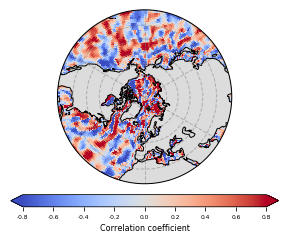

In [4]:
    print ('=================   OMET + atl + 0 & OHC + atl + 0 + band 30-35   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_atl_int_ORAS4_band_30_35)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=120, obj='detrend')    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_0_ORAS4_point.data)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    
    lag = 0
    k, r, p = meta.statistics.operator.linearRegress(stat_OHC_ORAS4._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(gphiv_ORAS4, glamv_ORAS4, mask_ORAS4 * r, p,
                                   label, ticks, os.path.join(output_path, 'omet_ohc',
                                   'spatial_ORAS4_atl_OHC_30_35_lag_{}_ORAS4_OMET_decadal.png'.format(lag)),
                                   gridtype='curvilinear')

=================   AMET + 0 & OMET + atl + 0 + 60N   =================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
A time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


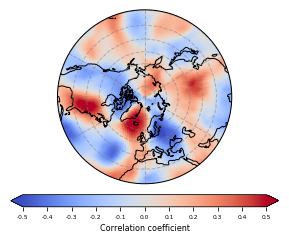

In [12]:
    print ('=================   AMET + 0 & OMET + atl + 0 + 60N   =================')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI_point)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=12, obj='detrend')
    lag = 6
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_AMET_ERAI._lowpass, lag)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(latitude_AMET_ERAI, longitude_AMET_ERAI, r, p,
                                   label, ticks, os.path.join(output_path, 'amet_omet',
                                   'spatial_ORAS4_atl_OMET_60N_lag_{}_ERAI_AMET_annual.png'.format(lag)))

=================   AMET + 0 & OHC + 0   =================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
A time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on curvilinear grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


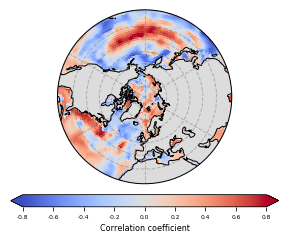

In [11]:
    print ('=================   AMET + 0 + 60N & OHC + 0   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_0_ORAS4_point)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=60, obj='detrend')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI[:,:,54])
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    
    lag = 24
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OHC_ORAS4._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(gphiv_ORAS4, glamv_ORAS4, mask_ORAS4*r, p,
                                   label, ticks, os.path.join(output_path, 'amet_ohc',
                                   'spatial_ERAI_AMET_60N_lag_{}_ORAS4_OHC_interannual.png'.format(lag)),
                                   gridtype='curvilinear')

=================   OMET + 0 + 60N & OHC + 0   =================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
A time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.
Create a NorthPolarStereo view of input fields.
The input fields are originally on curvilinear grid


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


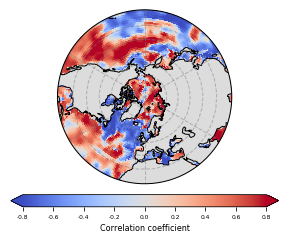

In [17]:
    print ('=================   OMET + 0 + 60N & OHC + 0   =================')
    stat_OHC_ORAS4 = meta.statistics.operator(OHC_0_ORAS4_point)
    stat_OHC_ORAS4.anomaly()
    stat_OHC_ORAS4.detrend()
    stat_OHC_ORAS4.lowpass(window=120, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_int_ORAS4[:,:,53])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    
    lag = -12
    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_OHC_ORAS4._lowpass, lag)
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.geograph(gphiv_ORAS4, glamv_ORAS4, mask_ORAS4*r, p,
                                   label, ticks, os.path.join(output_path, 'omet_ohc',
                                   'spatial_ORAS4_OMET_60N_lag_{}_ORAS4_OHC_decadal.png'.format(lag)),
                                   gridtype='curvilinear')    